In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Application de la méthode de Galerkine aux données
"""

DataFolder="C:/Users/Julie_000/Desktop/Stage/Stage_l3"
#DataFolder="E:/Clément/Julie/Stage_L3"

# Importations des librairies

In [2]:
from mat4py import loadmat #pour charger des .mat
import matplotlib
import matplotlib.pyplot as plt # pour tracer les figures
import os # pour modifier le dossier de travail
import numpy as np 
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)
import scipy as sc
import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver
from matplotlib.ticker import MaxNLocator #pour les courbes de niveau
from scipy.ndimage import gaussian_filter #Filtrage gaussien

from scipy.linalg import pinv as scpinv
from numpy.linalg import pinv as nppinv

import fonctions_projet_divergence as fpd#pour les données

colormap2=cm.PiYG#colormap

from mpl_toolkits.mplot3d import Axes3D#plot3D

# Chargement des données
## Choix des variables

In [3]:
prof=15 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)
m=5

## Constitution des tableaux
### Données brutes

In [4]:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseul.mat') # Charge les données dans la variable manip

piv=fpd.PIV(prof,manips)#données pour la profondeur

P=fpd.nb_plan(prof)#nombre de plan dans la profondeur choisie

u,v,x,y,z=fpd.donnees2(P,piv)
print(np.shape(u),np.shape(v),np.shape(x),np.shape(y),np.shape(z))

#tableau des z:
z=np.reshape(z,(P,1))
z_2D=np.hstack((z,z))
for i in range(57):
    z_2D=np.hstack((z_2D,z))
print(np.shape(z_2D))

z_3D=np.hstack((z_2D,z_2D))
for i in range(57):
    z_3D=np.hstack((z_3D,z_2D))
z_3D=np.reshape(z_3D,(P,59,59))
print(np.shape(z_3D))

(49, 60, 60) (49, 60, 60) (49, 60, 60) (49, 60, 60) (49,)
(49, 59)
(49, 59, 59)


### Divergence

In [5]:
div_2D=np.zeros((P,59,59))
dx=np.zeros((P,59,59))
dy=np.zeros((P,59,59))

for plan in range(P):
    div_2D[plan],dx[plan],dy[plan]=fpd.divergence2D_gauss(u[plan],v[plan],x[plan],y[plan],1)
    
print(np.shape(div_2D))

(49, 59, 59)


### vz

In [6]:
vz=fpd.methode_Galerkine(u,v,x,y,z,P,m,prof)
print(np.shape(vz))

NameError: name 'fpd' is not defined

# Test de la divergence 3D
## Dérivation de vz

In [ ]:
def deriv3D(vz,z,axis):
    """Dérive un tableau 3D y par rapport à x suivant un axe donné"""
    if vz.shape!=z.shape:
        z_good_shape=z[:-1,:,:]
    else:
        z_good_shape=z
    if axis==0:
        dvz=(vz[1:,:,:]-vz[:-1,:,:])/(z_good_shape[1:,:,:]-z_good_shape[:-1,:,:])#Donc là le tableau est de taille (P-1,n,n)
        return(dvz)

In [ ]:
dvz1=deriv3D(vz,z_3D,0)
print(np.shape(dvz1))
print(np.max(div_2D))

## Avec la méthode Galerkine

\partial_{z}v_{z}= -Ma

In [7]:
def dvz_methode_Galerkine(u,v,x,y,z,P,m,h):
    "Applique la méthode Galerkine"
    #divergence bidimensionelle
    div_2D=np.zeros((P,59,59))
    dx=np.zeros((P,59,59))
    dy=np.zeros((P,59,59))
    for plan in range(P):
        div_2D[plan],dx[plan],dy[plan]=fpd.divergence2D_gauss(u[plan],v[plan],x[plan],y[plan],2)
    #Matrice pinv
    M=np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi/h*z) for n in range(1,m+1)]))
    pinv=nppinv(M)
    #Calcul des coefficients
    div_2D=np.reshape(div_2D,(P,59*59))
    a=np.matmul(pinv,div_2D)
    #calcul de dvz
    dvz=-np.matmul(M,a)
    dvz=np.reshape(dvz,(P,59,59))
    return(dvz)

In [8]:
dvz=dvz_methode_Galerkine(u,v,x,y,z,P,m,prof)

## Remise des tableaux à la bonne shape

In [12]:
#print(np.shape(div_2D),np.shape(dvz1))

#div_3D1=div_2D[:-1,:,:]+dvz1
div_3D=div_2D+dvz

print(np.max(div_3D))
print(div_3D)

2.1398461229155643
[[[ 4.88162822e-03  8.33697306e-03  1.02285652e-02 ...  4.40448282e-02
   -3.34025234e-03 -5.50888236e-02]
  [ 5.65401229e-03  9.28193225e-03  1.12372917e-02 ...  4.64218769e-02
    9.06799616e-03 -3.12764293e-02]
  [ 6.30395705e-03  1.01048928e-02  1.20001556e-02 ...  3.87047228e-02
    4.24379073e-03 -3.26604802e-02]
  ...
  [-1.63806446e-01 -1.33907705e-01 -7.97879943e-02 ...  2.37285950e-02
    2.14444490e-02  8.95606458e-03]
  [-2.09042266e-01 -1.42814583e-01 -7.20357353e-02 ...  2.87841858e-02
    2.59459529e-02  8.72920843e-03]
  [-1.00557865e-01 -8.49197575e-02 -5.72268274e-02 ...  2.41043386e-02
    2.65941331e-02  1.16573376e-02]]

 [[ 4.65206323e-03  7.96628678e-03  9.84642523e-03 ...  6.27601240e-03
    5.77075906e-03  3.16650905e-03]
  [ 5.35004251e-03  8.81247757e-03  1.07587030e-02 ...  5.08412546e-03
    4.51402940e-03  2.02750213e-03]
  [ 5.87106000e-03  9.47199377e-03  1.13716104e-02 ...  4.59778639e-03
    4.07533461e-03  1.71689470e-03]
  ...
  [ 

In [13]:
#print(div_3D)
print(np.allclose(div_3D,np.zeros(np.shape(div_3D))))

False


## De façon relative

In [14]:
r=np.where(div_2D<0.01,0,np.abs(div_3D)/np.abs(div_2D))
seuil=0.1
print(np.max(r))
print('pourcentage de points où r < {}  :  {} %'.format(seuil,np.round(100*np.sum(r<seuil*np.ones(np.shape(r)))/np.size(r),decimals=1)))

47.4258765837671
pourcentage de points où r < 0.1  :  79.3 %


C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


# Divergence dans les plans à x ou y fixes
## Fonction

In [16]:
def divergence_plans(u,v,x,y,sigma):
    "Applique le programme de divergence2D avec filtre gaussien sur la vitesse"
    #Filtrage
    u_filtre=gaussian_filter(u,sigma)
    v_filtre=gaussian_filter(v,sigma)
    #dérivation
    du_filtre,dv_filtre=fpd.deriv(u_filtre,x,1),fpd.deriv(v_filtre,y,0)
    #shape
    du_filtre,dv_filtre=fpd.good_shape(du_filtre),fpd.good_shape(dv_filtre)
    return(du_filtre,dv_filtre)

In [17]:
print(np.shape(div_2D),np.shape(dvz),np.shape(z_3D))

(49, 59, 59) (49, 59, 59) (49, 59, 59)


## Création des tableaux

In [18]:
u,v,x,y,z=fpd.donnees2(P,piv)
du=np.zeros(np.shape(div_2D))
dv=np.zeros(np.shape(div_2D))
for plan in range(P):
    du[plan],dv[plan] = divergence_plans(u[plan],v[plan],x[plan],y[plan],1)
print(np.shape(du),np.shape(dvz))

(49, 59, 59) (49, 59, 59)


In [19]:
div_x=fpd.somme(dvz,dv)
div_y=fpd.somme(dvz,du)

## Plot
### Fonction

In [20]:
def plot_divergence(div,dx,dy,title,xlabel,ylabel):
    "Tracé des divergences"
    #norme
    vmax,vmin=np.max(div),np.min(div)
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=25).tick_values(vmin,vmax)
    
    fig, l0 = plt.subplots(num=title)
    im0 = l0.contourf(dx,dy,div,levels=levels, cmap=colormap2,norm=norm)
    fig.colorbar(im0,ax=l0)
    l0.set_xlabel(xlabel)
    l0.set_ylabel(ylabel)
   
    fig.suptitle(title,fontsize=16)
    fig.tight_layout(pad = 3)
    fig.suptitle(title,fontsize=20)
    plt.show()

### à x fixe

<IPython.core.display.Javascript object>


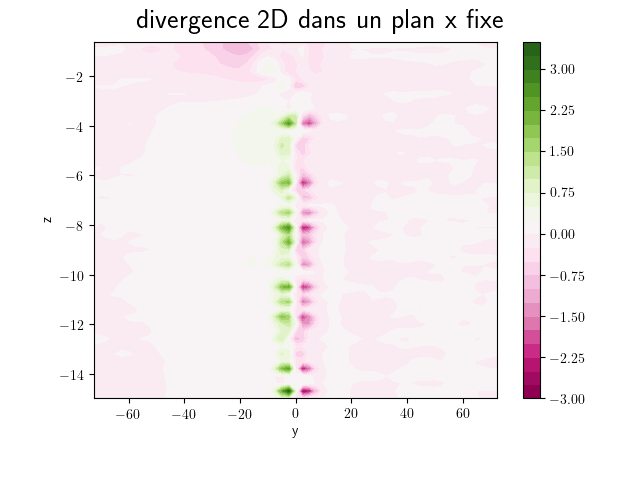

In [26]:
%matplotlib notebook
plan=31
plot_divergence(div_x[:,:,plan],dy[:,:,plan],-z_3D[:,:,plan],'divergence 2D dans un plan x fixe','y','z')

### à y fixe

<IPython.core.display.Javascript object>


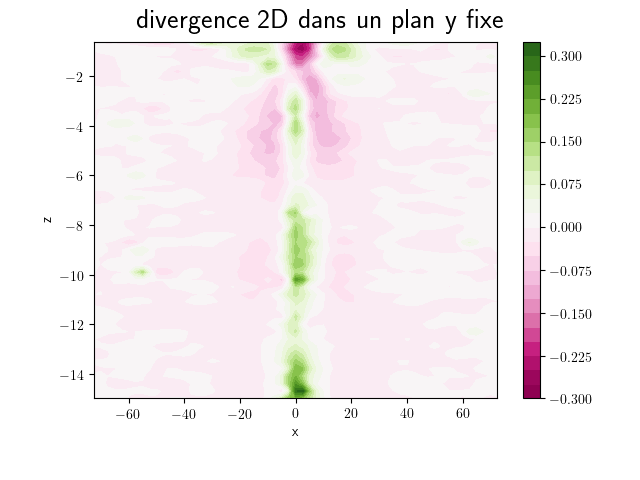

In [25]:
%matplotlib notebook
plan=32
plot_divergence(div_y[:,plan,:],dx[:,plan,:],-z_3D[:,plan,:],'divergence 2D dans un plan y fixe','x','z')

# Point de pompage
## Evolution de la position en fonction de la hauteur
### Fonction

In [28]:
def indices_x_y_max(div,P):
    indices=np.zeros((P,2))
    for i in range(P):
        indices[i] = np.unravel_index(np.argmax(np.abs(div[i]), axis=None), (P,59))
    return(indices)


### Constitution des tableaux

In [29]:
y_ind,x_ind=indices_x_y_max(div_2D,P)[:,0],indices_x_y_max(div_2D,P)[:,1]
print(x_ind)
print(indices_x_y_max(div_2D,P))

[28. 29. 30. 29. 29. 29. 30. 29. 28. 29. 29. 31. 28. 32. 31. 31. 28. 31.
 32. 31. 29. 31. 27. 31. 27. 31. 31. 31. 31. 31. 31. 28. 31. 31. 30. 31.
 31. 29. 31. 31. 31. 31. 29. 31. 31. 30. 31. 31. 31.]
[[24. 28.]
 [24. 29.]
 [24. 30.]
 [24. 29.]
 [24. 29.]
 [26. 29.]
 [20. 30.]
 [26. 29.]
 [26. 28.]
 [26. 29.]
 [32. 29.]
 [31. 31.]
 [26. 28.]
 [28. 32.]
 [27. 31.]
 [27. 31.]
 [26. 28.]
 [27. 31.]
 [28. 32.]
 [31. 31.]
 [26. 29.]
 [31. 31.]
 [27. 27.]
 [31. 31.]
 [27. 27.]
 [31. 31.]
 [31. 31.]
 [31. 31.]
 [27. 31.]
 [31. 31.]
 [31. 31.]
 [25. 28.]
 [27. 31.]
 [31. 31.]
 [26. 30.]
 [31. 31.]
 [27. 31.]
 [26. 29.]
 [31. 31.]
 [27. 31.]
 [27. 31.]
 [27. 31.]
 [26. 29.]
 [27. 31.]
 [27. 31.]
 [32. 30.]
 [32. 31.]
 [31. 31.]
 [27. 31.]]


### plot
#### fonction de plot

In [30]:
def plot_indices(indices,z,title,xlabel):
    fig,ax=plt.subplots(num=title)
    ax.plot(indices,z,color='steelblue',linestyle='',marker='.')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('z')
    fig.suptitle(title,fontsize=16)
    plt.show()

#### Evolution en x

<IPython.core.display.Javascript object>


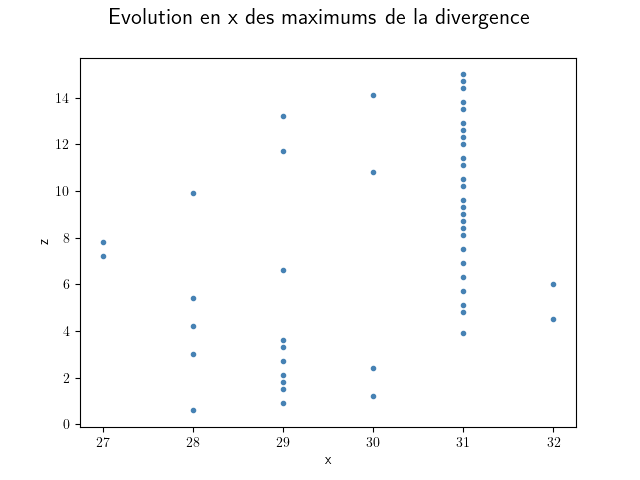

In [31]:
plot_indices(x_ind,z,'Evolution en x des maximums de la divergence','x')

#### Evolution en y

<IPython.core.display.Javascript object>


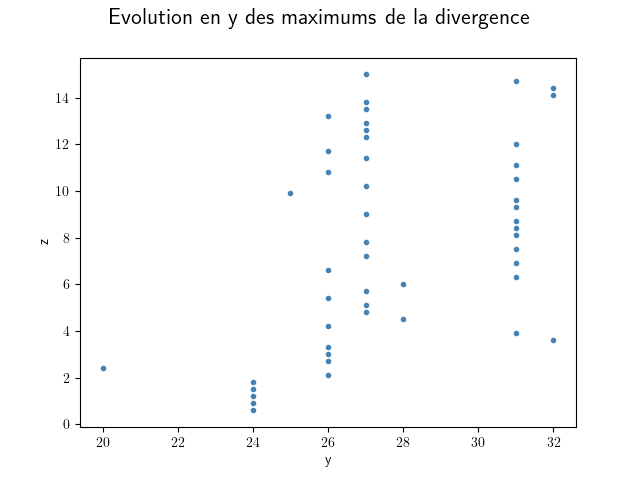

In [32]:
plot_indices(y_ind,z,'Evolution en y des maximums de la divergence','y')

## Affinage

In [33]:
print(dy[0,:29,0])

[-72.55871446 -70.08652658 -67.55253399 -65.01854141 -62.54635352
 -60.07416564 -57.54017305 -55.00618047 -52.53399258 -50.0618047
 -47.52781211 -44.99381953 -42.52163164 -40.04944376 -37.51545117
 -34.98145859 -32.5092707  -30.03708282 -27.50309023 -24.96909765
 -22.49690977 -20.02472188 -17.55253399 -15.01854141 -12.48454883
 -10.01236094  -7.54017305  -5.00618047  -2.47218789]


In [34]:
y_ind2,x_ind2=indices_x_y_max(div_2D[:,:30,:],P)[:,0],indices_x_y_max(div_2D[:,:30,:],P)[:,1]
print(y_ind2)
print(indices_x_y_max(div_2D[:,:30,:],P))

[24. 24. 24. 24. 24. 26. 20. 26. 26. 26. 26. 27. 26. 28. 27. 27. 26. 27.
 28. 27. 26. 28. 27. 27. 27. 27. 28. 27. 27. 27. 27. 25. 27. 27. 26. 27.
 27. 26. 26. 27. 27. 27. 26. 27. 27. 25. 24. 27. 27.]
[[24. 28.]
 [24. 29.]
 [24. 30.]
 [24. 29.]
 [24. 29.]
 [26. 29.]
 [20. 30.]
 [26. 29.]
 [26. 28.]
 [26. 29.]
 [26. 28.]
 [27. 31.]
 [26. 28.]
 [28. 32.]
 [27. 31.]
 [27. 31.]
 [26. 28.]
 [27. 31.]
 [28. 32.]
 [27. 31.]
 [26. 29.]
 [28. 32.]
 [27. 27.]
 [27. 31.]
 [27. 27.]
 [27. 31.]
 [28. 32.]
 [27. 31.]
 [27. 31.]
 [27. 31.]
 [27. 31.]
 [25. 28.]
 [27. 31.]
 [27. 31.]
 [26. 30.]
 [27. 31.]
 [27. 31.]
 [26. 29.]
 [26. 29.]
 [27. 31.]
 [27. 31.]
 [27. 31.]
 [26. 29.]
 [27. 31.]
 [27. 31.]
 [25. 29.]
 [24. 29.]
 [27. 31.]
 [27. 31.]]


### Evolution en x

<IPython.core.display.Javascript object>


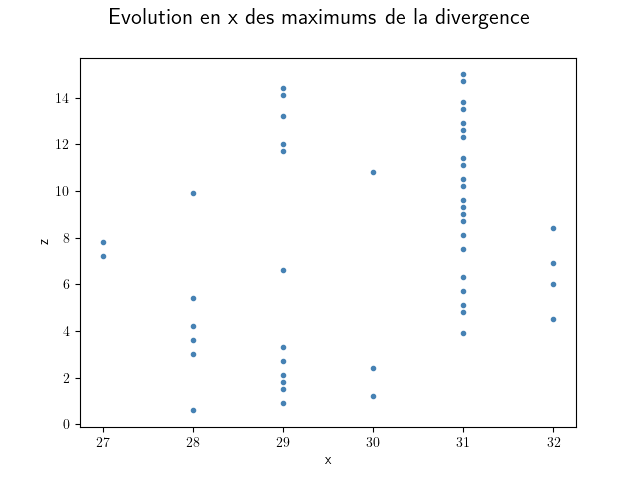

In [35]:
%matplotlib notebook
plot_indices(x_ind2,z,'Evolution en x des maximums de la divergence','x')

### Evolution en y

<IPython.core.display.Javascript object>


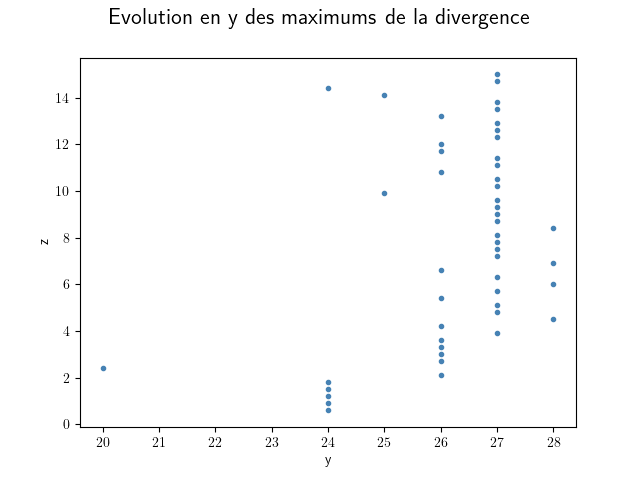

In [36]:
%matplotlib notebook
plot_indices(y_ind2,z,'Evolution en y des maximums de la divergence','y')

## Indices des premiers max
### Fonction

In [37]:
def points_de_pompage(div,nmax):
    indices=np.zeros((nmax,3))
    maximums=np.zeros((nmax))
    new_div=np.copy(div)
    for i in range(nmax):
        indices[i] = np.unravel_index(np.argmax(new_div, axis=None), div_2D.shape)
        maximums[i]=np.max(new_div)
        new_div=np.where(new_div==maximums[i],0,new_div)
    return(maximums,indices)

### Constitution des tableaux

In [ ]:
nmax=20 #Choix de nmax
maximums,indices=points_de_pompage(div_2D,nmax)
    
print(indices)
print(maximums)

## Maximum de la dérivée de la divergence
### Fonction

In [ ]:
ddiv=deriv3D(div_3D,z_3D,0)
print(np.shape(z_3D),np.shape(div_3D))
print(np.shape(ddiv))

### Constitution des tableaux

In [ ]:
nmax=20
dmaximums,dindices=points_de_pompage(ddiv,nmax)
print(dindices)
print(dmaximums)